## CSC420 - Assignment 3

## Humzah Khan

#### Question 3 - Local Descriptors: HOGS (70)

Exploration of Image Gradients, and Directions

In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# Upload and Read Image (You can also use your own image file)
from google.colab import files

def explore_gradients_directions(img, threshold=20):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

  # Convert image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


  # Compute gradients using Sobel operators
  Gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
  Gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

  # Compute gradient magnitude and direction
  magnitude = np.sqrt(Gx**2 + Gy**2)
  direction = np.arctan2(Gy, Gx) * (180 / np.pi)  # Convert radians to degrees

  # Store the original magnitude for visualization
  magnitude_before_threshold = magnitude.copy()

  # Threshold small gradient magnitudes
  #threshold = 5  # Adjustable threshold value
  magnitude[magnitude < threshold] = 0

  # Plot the magnitude before and after thresholding
  fig, axes = plt.subplots(1, 2, figsize=(12, 6))

  # Magnitude before thresholding
  axes[0].imshow(magnitude_before_threshold, cmap='gray')
  axes[0].set_title("Gradient Magnitude Before Thresholding")
  axes[0].axis("off")

  # Magnitude after thresholding
  axes[1].imshow(magnitude, cmap='gray')
  axes[1].set_title("Gradient Magnitude After Thresholding")
  axes[1].axis("off")

  plt.show()

  # Define cell size for segmentation
  cell_size = 20
  height, width = gray.shape
  cell_rows, cell_cols = height // cell_size, width // cell_size

  # Quantization of orientation into 6 bins
  angle_bins = np.array([-15, 15, 45, 75, 105, 135, 165])  # Bin edges
  num_bins = len(angle_bins) - 1
  histogram = np.zeros((cell_rows, cell_cols, num_bins))

  import matplotlib.colors as mcolors
  bin_labels = ["-15° to 15°", "15° to 45°", "45° to 75°", "75° to 105°", "105° to 135°", "135° to 165°"]
  colors = ['blue', 'green', 'yellow', 'orange', 'red', 'purple']  # Assign colors to bins

  # Assign a color to each pixel based on its gradient direction
  direction_colored = np.zeros(gray.shape, dtype=np.uint8)

  for i in range(len(angle_bins) - 1):
      mask = (direction >= angle_bins[i]) & (direction < angle_bins[i + 1])
      direction_colored[mask] = i + 1  # Assign bin index (1 to 6)

  # Create a colormap for visualization
  cmap = mcolors.ListedColormap(colors)
  bounds = np.arange(len(angle_bins))  # Bin boundaries
  norm = mcolors.BoundaryNorm(bounds, cmap.N)

  # Plot the gradient direction visualization
  fig, ax = plt.subplots(figsize=(10, 8))
  img_plot = ax.imshow(direction_colored, cmap=cmap, norm=norm)
  ax.set_title("Gradient Directions Visualization")
  ax.axis("off")

  # Create a color legend
  cbar = plt.colorbar(img_plot, ticks=np.arange(len(bin_labels)) + 0.5)
  cbar.set_ticklabels(bin_labels)

  plt.show()



  # Histogram of gradient directions (count per bin)
  direction_histogram = np.zeros(len(angle_bins) - 1)
  for i in range(len(angle_bins) - 1):
      mask = (direction >= angle_bins[i]) & (direction < angle_bins[i + 1])
      direction_histogram[i] = np.sum(mask)  # Count number of pixels in each bin

  # Plot histogram of gradient directions
  plt.figure(figsize=(10, 5))
  plt.bar(bin_labels, direction_histogram, color=colors, edgecolor="black")
  plt.xlabel("Gradient Direction Bins")
  plt.ylabel("Number of Pixels")
  plt.title("Histogram of Gradient Directions")
  plt.xticks(rotation=45)
  plt.grid(axis="y", linestyle="--", alpha=0.7)
  plt.show()

  # Plot histogram of gradient magnitudes
  plt.figure(figsize=(10, 5))
  plt.hist(magnitude.ravel(), bins=50, color="cyan", edgecolor="black", alpha=0.7)
  plt.xlabel("Gradient Magnitude")
  plt.ylabel("Number of Pixels")
  plt.title("Histogram of Gradient Magnitudes")
  plt.grid(axis="y", linestyle="--", alpha=0.7)
  plt.show()

  return



### Summed Gradient Approach

In [26]:
def summed_gradient_approach(img, threshold = 20):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

  # Convert image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


  # Compute gradients using Sobel operators
  Gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
  Gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

  # Compute gradient magnitude and direction
  magnitude = np.sqrt(Gx**2 + Gy**2)
  direction = np.arctan2(Gy, Gx) * (180 / np.pi)  # Convert radians to degrees

  # Store the original magnitude for visualization
  magnitude_before_threshold = magnitude.copy()

  # Threshold small gradient magnitudes
  #threshold = 5  # Adjustable threshold value
  magnitude[magnitude < threshold] = 0

  # Define cell size for segmentation
  cell_size = 20
  height, width = gray.shape
  cell_rows, cell_cols = height // cell_size, width // cell_size

  # Quantization of orientation into 6 bins
  angle_bins = np.array([-15, 15, 45, 75, 105, 135, 165])  # Bin edges
  num_bins = len(angle_bins) - 1
  histogram = np.zeros((cell_rows, cell_cols, num_bins))

    # Fill the histogram with accumulated magnitudes
  for i in range(cell_rows):
      for j in range(cell_cols):
          # Extract gradients for the cell
          cell_magnitude = magnitude[i * cell_size: (i + 1) * cell_size,
                                    j * cell_size: (j + 1) * cell_size]
          cell_direction = direction[i * cell_size: (i + 1) * cell_size,
                                    j * cell_size: (j + 1) * cell_size]

          # Quantize the directions into bins
          for k in range(num_bins):
              mask = (cell_direction >= angle_bins[k]) & (cell_direction < angle_bins[k + 1])
              histogram[i, j, k] = np.sum(cell_magnitude[mask])

  # Visualization using quiver plot
  fig, ax = plt.subplots(figsize=(10, 10))
  ax.imshow(gray, cmap='gray')

  # Superimpose quiver plots
  X, Y = np.meshgrid(np.arange(cell_cols) * cell_size, np.arange(cell_rows) * cell_size)

  # Normalize histogram values to a reasonable range
  histogram_max = np.max(histogram)  # Find max value for scaling
  histogram_min = np.min(histogram[histogram > 0])  # Smallest nonzero value
  histogram_norm = (histogram - histogram_min) / (histogram_max - histogram_min + 1e-5)  # Normalize between 0 and 1

  # Scale factor to make arrows visible (adjust as needed)
  arrow_scale = 20

  for k in range(num_bins):
      angle = (angle_bins[k] + angle_bins[k + 1]) / 2  # Midpoint of bin range
      U = np.cos(np.radians(angle)) * histogram_norm[:, :, k] * arrow_scale
      V = np.sin(np.radians(angle)) * histogram_norm[:, :, k] * arrow_scale
      ax.quiver(X, Y, U, V, color='r', angles='xy', scale_units='xy', scale=1, alpha=0.6, headwidth=0, headlength=0, headaxislength=0)

  for k in range(num_bins):
      angle = (angle_bins[k] + angle_bins[k + 1]) / 2  + 180 # Midpoint of bin range
      U = np.cos(np.radians(angle)) * histogram_norm[:, :, k] * arrow_scale
      V = np.sin(np.radians(angle)) * histogram_norm[:, :, k] * arrow_scale
      ax.quiver(X, Y, U, V, color='r', angles='xy', scale_units='xy', scale=1, alpha=0.6, headwidth=0, headlength=0, headaxislength=0)


  plt.title("HOG-like Feature Visualization Summed-Gradients Quiver Plot")
  plt.show()

  return histogram, histogram_norm

### Occurences Approach

In [31]:
def occurences_approach(img, threshold =20, arrow_scale=20):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

  # Convert image to grayscale
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


  # Compute gradients using Sobel operators
  Gx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
  Gy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

  # Compute gradient magnitude and direction
  magnitude = np.sqrt(Gx**2 + Gy**2)
  direction = np.arctan2(Gy, Gx) * (180 / np.pi)  # Convert radians to degrees

  # Store the original magnitude for visualization
  magnitude_before_threshold = magnitude.copy()

  # Threshold small gradient magnitudes
  #threshold = 5  # Adjustable threshold value
  magnitude[magnitude < threshold] = 0

  # Define cell size for segmentation
  cell_size = 20
  height, width = gray.shape
  cell_rows, cell_cols = height // cell_size, width // cell_size

  # Quantization of orientation into 6 bins
  angle_bins = np.array([-15, 15, 45, 75, 105, 135, 165])  # Bin edges
  num_bins = len(angle_bins) - 1
  #histogram = np.zeros((cell_rows, cell_cols, num_bins))

  histogram_freq = np.zeros((cell_rows, cell_cols, num_bins))

  # Compute histogram frequency instead of summing magnitudes
  for i in range(cell_rows):
      for j in range(cell_cols):
          # Extract gradients for the cell
          cell_magnitude = magnitude[i * cell_size: (i + 1) * cell_size,
                                      j * cell_size: (j + 1) * cell_size]
          cell_direction = direction[i * cell_size: (i + 1) * cell_size,
                                      j * cell_size: (j + 1) * cell_size]

          # Quantize the directions into bins (count occurrences instead of sum)
          for k in range(num_bins):
              mask = (cell_direction >= angle_bins[k]) & (cell_direction < angle_bins[k + 1])
              histogram_freq[i, j, k] = np.sum(mask)  # Count occurrences

  # Visualization using quiver plot
  fig, ax = plt.subplots(figsize=(10, 10))
  ax.imshow(gray, cmap='gray')

  # Superimpose quiver plots
  X, Y = np.meshgrid(np.arange(cell_cols) * cell_size, np.arange(cell_rows) * cell_size)

  # Normalize the frequency values for a consistent scale
  histogram_max = np.max(histogram_freq)
  histogram_norm = histogram_freq / (histogram_max + 1e-5)  # Normalize between 0 and 1



  # **First loop: Original direction bins**
  for k in range(num_bins):
      angle = (angle_bins[k] + angle_bins[k + 1]) / 2  # Midpoint of bin range
      U = np.cos(np.radians(angle)) * histogram_norm[:, :, k] * arrow_scale
      V = np.sin(np.radians(angle)) * histogram_norm[:, :, k] * arrow_scale
      ax.quiver(X, Y, U, V, color='r', angles='xy', scale_units='xy', scale=1,
                alpha=0.6, headwidth=0, headlength=0, headaxislength=0)  # Removes arrowheads

  # **Second loop: 180-degree mirrored vectors for symmetry**
  for k in range(num_bins):
      angle = (angle_bins[k] + angle_bins[k + 1]) / 2 + 180  # Midpoint + 180°
      U = np.cos(np.radians(angle)) * histogram_norm[:, :, k] * arrow_scale
      V = np.sin(np.radians(angle)) * histogram_norm[:, :, k] * arrow_scale
      ax.quiver(X, Y, U, V, color='r', angles='xy', scale_units='xy', scale=1,
                alpha=0.6, headwidth=0, headlength=0, headaxislength=0)  # Removes arrowheads

  plt.title("HOG Visualization Using Frequency-Based Histogram (Symmetric Quiver)")
  plt.show()
  return histogram_freq, histogram_norm

### Compute Normalized Histogram

In [18]:
import numpy as np
import cv2

def compute_l2_normalized_hog(histogram, epsilon=1e-3):
    """
    Computes L2-normalized HOG feature descriptors over 2x2 blocks with stride 1.

    Parameters:
        histogram (numpy array): The raw HOG histogram with shape (m, n, 6).
        epsilon (float): Small constant to prevent division by zero.

    Returns:
        normalized_histogram (numpy array): L2-normalized HOG feature descriptors with shape (m-1, n-1, 24).
    """
    # Get the shape of the histogram (m, n, bins)
    m, n, num_bins = histogram.shape

    # New histogram shape after 2x2 block normalization (m-1, n-1, 24)
    normalized_histogram = np.zeros((m-1, n-1, 2 * 2 * num_bins))  # Shape (m-1, n-1, 24)

    # Iterate over each block in a sliding 2x2 window with stride 1
    for i in range(m - 1):
        for j in range(n - 1):
            # Extract the 2x2 block (flatten into a single vector)
            block_vector = np.hstack([
                histogram[i, j, :], histogram[i, j+1, :],   # First row of the block
                histogram[i+1, j, :], histogram[i+1, j+1, :] # Second row of the block
            ])

            # Compute L2 norm: sqrt(sum(h_i^2) + epsilon^2)
            l2_norm = np.sqrt(np.sum(block_vector ** 2) + epsilon ** 2)

            # Normalize the feature vector
            normalized_vector = block_vector / l2_norm

            # Store the result in the new histogram array
            normalized_histogram[i, j, :] = normalized_vector

    return normalized_histogram



Normalized HOG shape: (56, 53, 24)


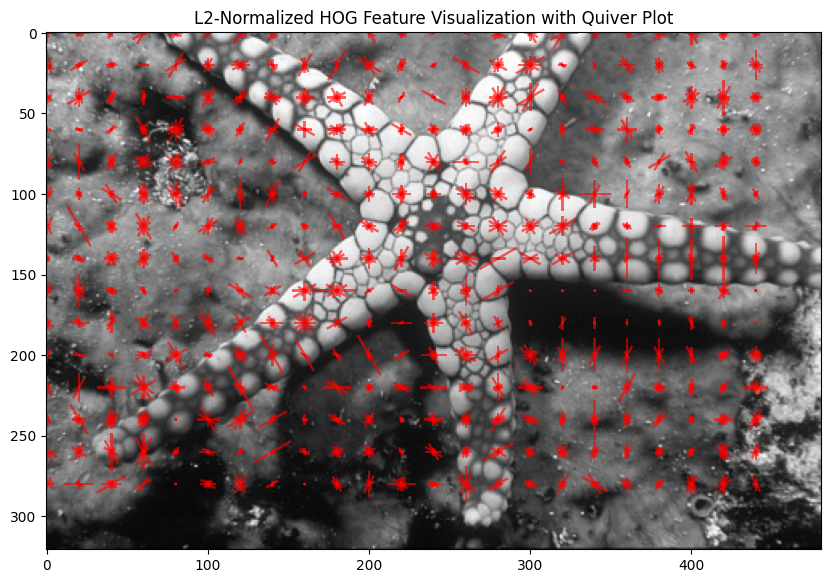

In [29]:
import matplotlib.pyplot as plt

def visualize_l2_hog(normalized_histogram, image, cell_size=20, arrow_scale=20):
    """
    Visualizes the L2-normalized HOG features using a quiver plot.

    Parameters:
        normalized_histogram (numpy array): L2-normalized HOG feature descriptors with shape (m-1, n-1, 24).
        gray_image (numpy array): The grayscale image used for reference.
        cell_size (int): The size of each HOG cell (default: 8).
        arrow_scale (float): Scale factor for quiver arrows (default: 5).
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Define new grid dimensions after normalization
    m, n, num_bins = normalized_histogram.shape  # Should be (m-1, n-1, 24)
    num_bins_per_cell = num_bins // 4  # We originally had 6 bins, so 24/4 = 6 bins per cell

    # Define angle bins (same as before)
    angle_bins = np.array([-15, 15, 45, 75, 105, 135, 165])  # Bin edges

    # Grid for quiver plot
    X, Y = np.meshgrid(np.arange(n) * cell_size, np.arange(m) * cell_size)

    # Plot the grayscale image as background
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(gray_image, cmap='gray')

    # Iterate over bins and plot quiver arrows
    for k in range(num_bins_per_cell):
        angle = (angle_bins[k] + angle_bins[k + 1]) / 2  # Midpoint of bin range

        # Extract corresponding bin values
        U = np.cos(np.radians(angle)) * normalized_histogram[:, :, k] * arrow_scale
        V = np.sin(np.radians(angle)) * normalized_histogram[:, :, k] * arrow_scale

        # Plot the main quiver
        ax.quiver(X, Y, U, V, color='r', angles='xy', scale_units='xy', scale=1,
                  alpha=0.6, headwidth=0, headlength=0, headaxislength=0)

        # Mirror quiver arrows for symmetry (add 180 degrees)
        U_mirror = np.cos(np.radians(angle + 180)) * normalized_histogram[:, :, k] * arrow_scale
        V_mirror = np.sin(np.radians(angle + 180)) * normalized_histogram[:, :, k] * arrow_scale
        ax.quiver(X, Y, U_mirror, V_mirror, color='r', angles='xy', scale_units='xy', scale=1,
                  alpha=0.6, headwidth=0, headlength=0, headaxislength=0)

    plt.title("L2-Normalized HOG Feature Visualization with Quiver Plot")
    plt.show()



## Save TXT File

In [20]:
def save_hog_to_file(normalized_histogram, filename):
    """
    Saves the L2-normalized HOG histogram as a single-line text file.

    Parameters:
        normalized_histogram (numpy array): L2-normalized HOG feature descriptors with shape (m-1, n-1, 24).
        filename (str): Name of the output text file (e.g., "image1.txt").
    """
    # Flatten the histogram into a 1D array (sequential row-wise)
    flattened_histogram = normalized_histogram.flatten()

    # Convert array to a single space-separated string
    histogram_str = ' '.join(map(str, flattened_histogram))

    # Save to a text file
    with open(filename, "w") as file:
        file.write(histogram_str)

    print(f"HOG features saved to {filename}")



HOG features saved to image1.txt


## Running Hog approaches for Image1.png

Saving image1.png to image1 (6).png


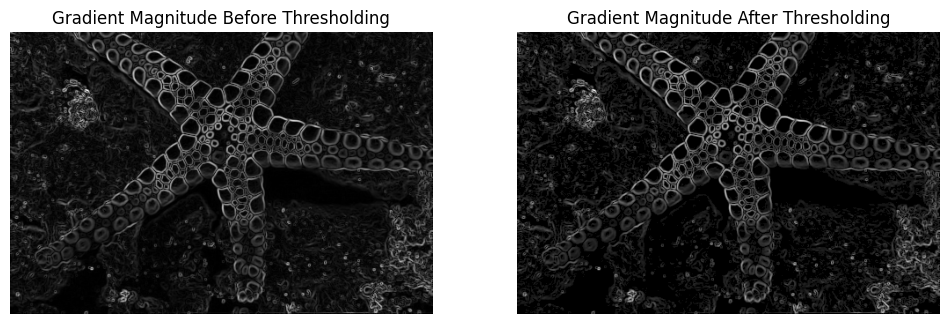

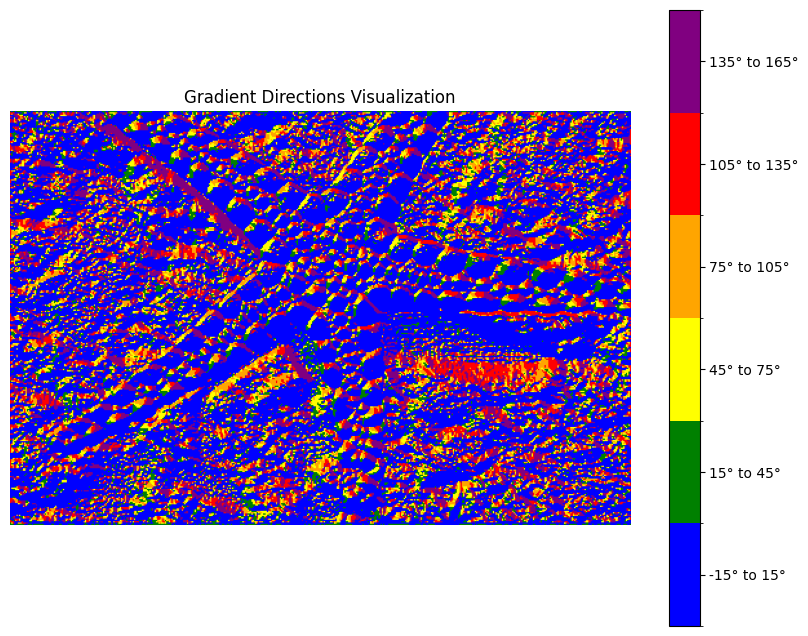

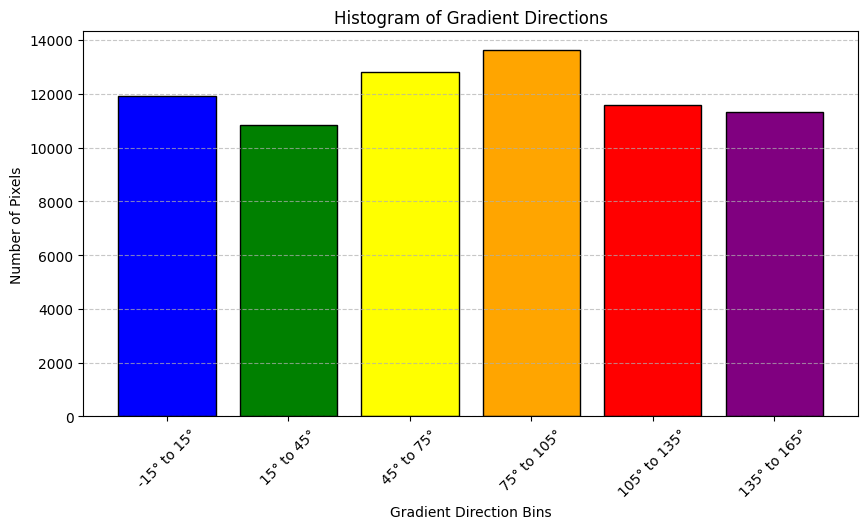

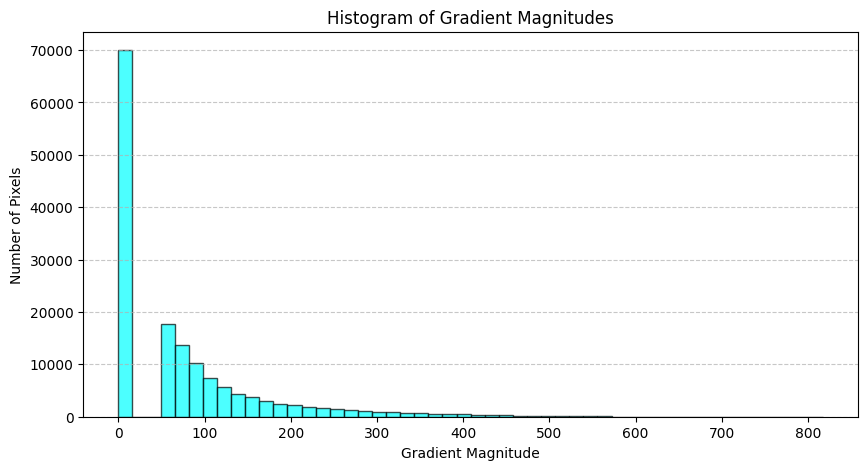

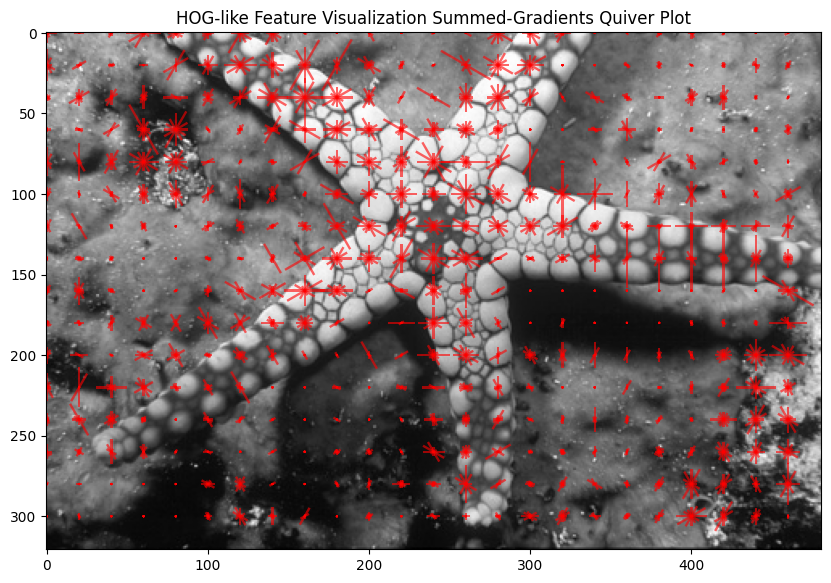

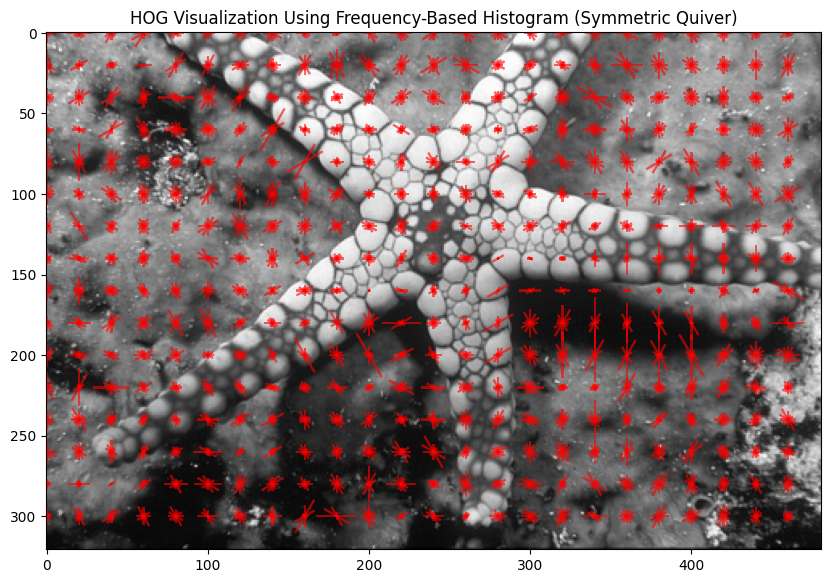

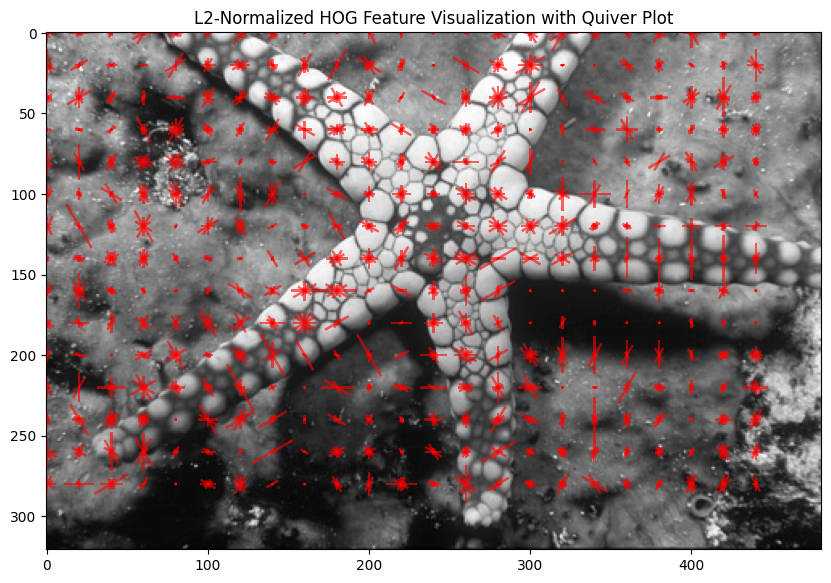

HOG features saved to image1.txt


In [34]:
uploaded = files.upload()  # Upload an image file manually
image_path = list(uploaded.keys())[0]

# Load the image
img = cv2.imread(image_path)

threshold = 50

# Empirically Assess Image 2
explore_gradients_directions(img, threshold)


# Q3.3 (Summed Gradients) - Image 1
histogram_sg, histogram_norm_sg = summed_gradient_approach(img, threshold)

# Q3.3 (Occurences) - Image 1
histogram_o, histogram_norm_o = occurences_approach(img, threshold)


# Q3.4 (Summed Gradients) - Image 1
normalized_hog = compute_l2_normalized_hog(histogram_sg)

# Q3.4 (Summed Gradients) - Image 1 Plot
visualize_l2_hog(normalized_hog, img)

# Q3.4 (Summed Gradients) - Image 1 Txt File
save_hog_to_file(normalized_hog, "image1.txt")

## Now repeating with image2.png

Saving image2.png to image2 (2).png


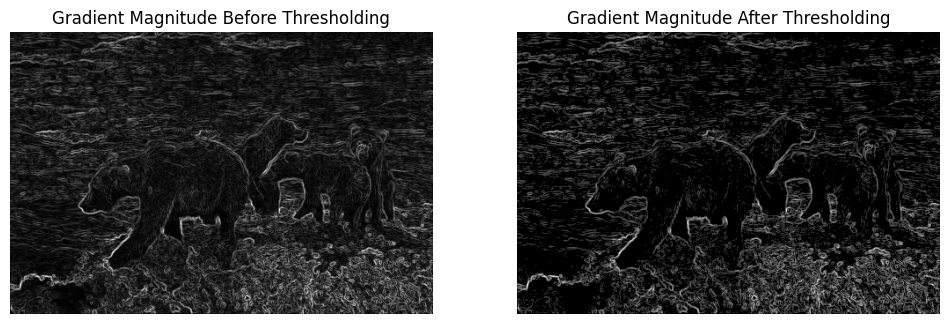

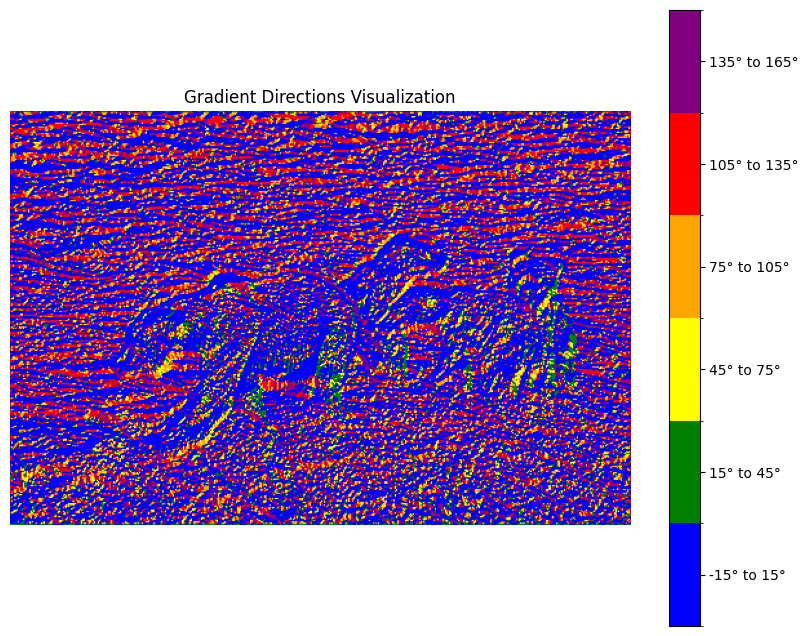

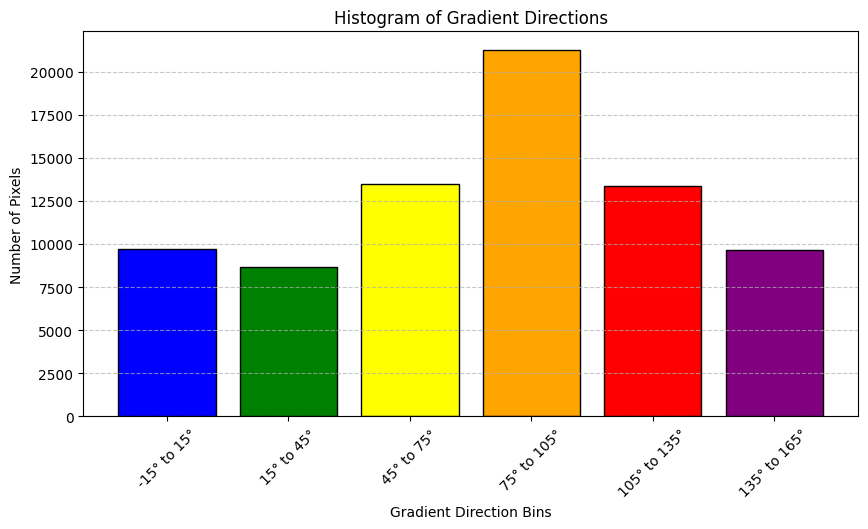

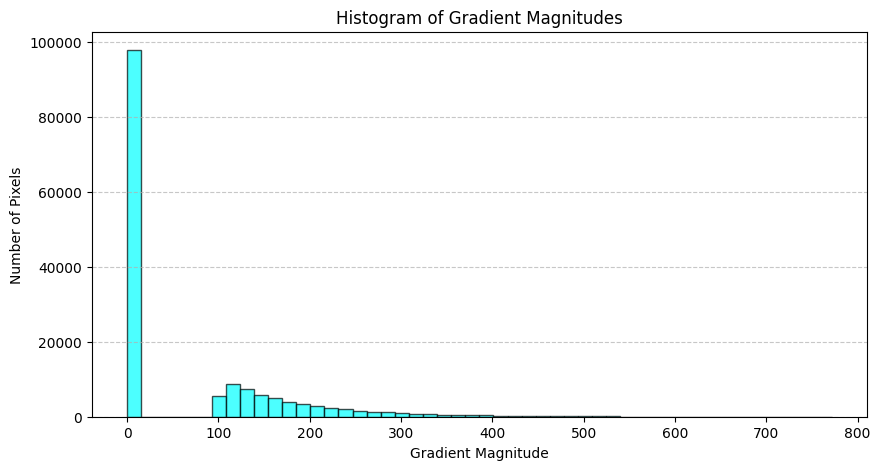

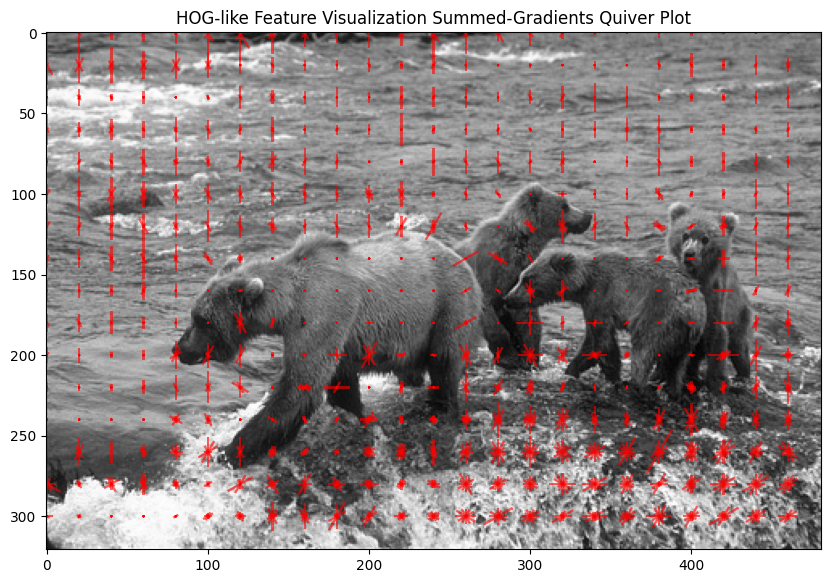

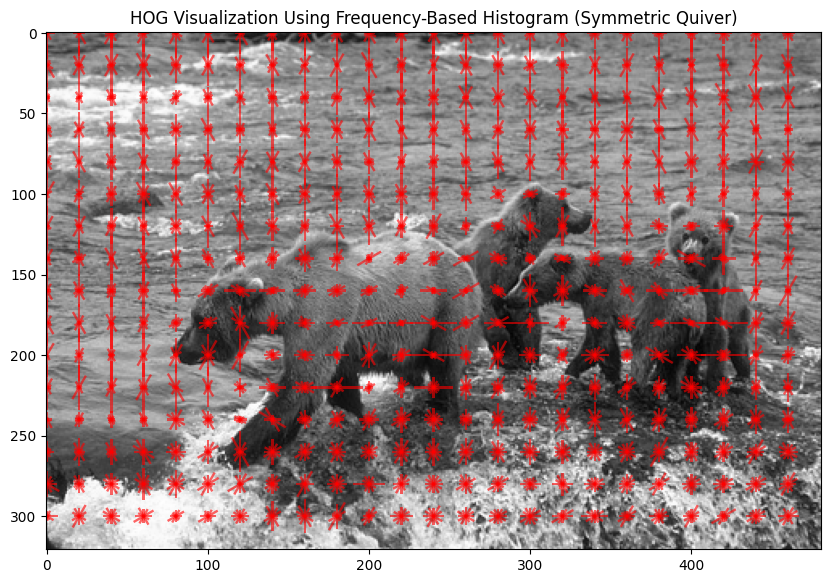

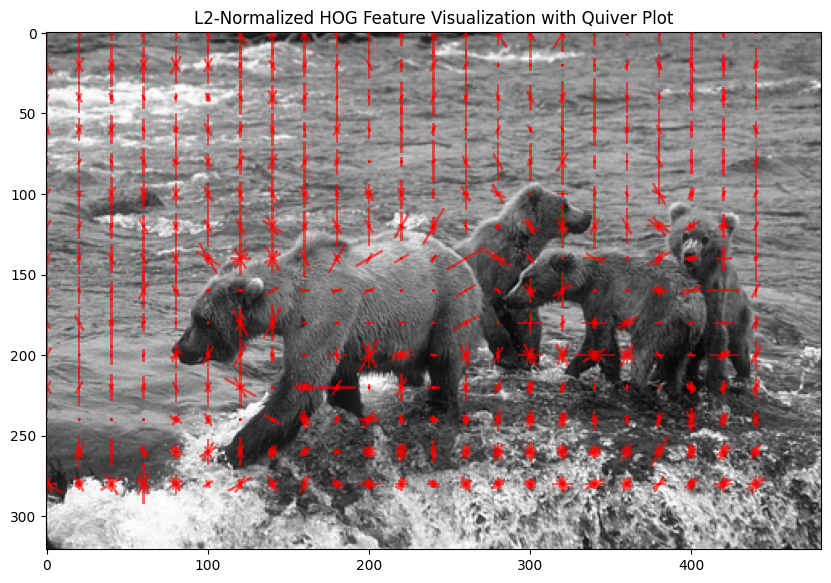

HOG features saved to image2.txt


In [37]:
uploaded = files.upload()  # Upload an image file manually
image_path = list(uploaded.keys())[0]

# Load the image
img = cv2.imread(image_path)

threshold = 100

# Empirically Assess Image 2
explore_gradients_directions(img, threshold)


# Q3.3 (Summed Gradients) - Image 2
histogram_sg, histogram_norm_sg = summed_gradient_approach(img, threshold)

# Q3.3 (Occurences) - Image 2
histogram_o, histogram_norm_o = occurences_approach(img, threshold)


# Q3.4 (Summed Gradients) - Image 2
normalized_hog = compute_l2_normalized_hog(histogram_sg)

# Q3.4 (Summed Gradients) - Image 2 Plot
visualize_l2_hog(normalized_hog, img)

# Q3.4 (Summed Gradients) - Image 2 Txt File
save_hog_to_file(normalized_hog, "image2.txt")

**Brief Discussion**

The Summed-Gradients approach seems to better capture low frequency features and strong prominent edges. However, the Occurence approach better captures the high frequency features and minute details in the image in a more balanced way. Notice how the first plot only has arrows visible around the profile of the star as well as its suction cups, and less signal from most of the background. Whereas in the second plot, there is a more gentle flow field within and around the star, however, the background is a lot more noisy too.  

***I prefer the Summed-Gradient approach and will use that going forward primarily***



## My Own Image (No Flash)

In [ ]:
uploaded = files.upload()  # Upload an image file manually
image_path = list(uploaded.keys())[0]

# Load the image
img = cv2.imread(image_path)

threshold = 100

# Empirically Assess Image 2
explore_gradients_directions(img, threshold)


# Q3.3 (Summed Gradients) - Image 3
histogram_sg, histogram_norm_sg = summed_gradient_approach(img, threshold)

# Q3.3 (Occurences) - Image 3
histogram_o, histogram_norm_o = occurences_approach(img, threshold)


# Q3.4 (Summed Gradients Norm) - Image 3
normalized_hog = compute_l2_normalized_hog(histogram_sg)

# Q3.4 (Summed Gradients Norm) - Image 3 Plot
visualize_l2_hog(normalized_hog, img)

# Q3.4 (Summed Gradients) - Image 3 Txt File
save_hog_to_file(normalized_hog, "Noflash.txt")

## My Own Image (Flash)

In [ ]:
uploaded = files.upload()  # Upload an image file manually
image_path = list(uploaded.keys())[0]

# Load the image
img = cv2.imread(image_path)

threshold = 100

# Empirically Assess Image 4
explore_gradients_directions(img, threshold)


# Q3.4 (Summed Gradients) - Image 4
histogram_sg, histogram_norm_sg = summed_gradient_approach(img, threshold)

# Q3.4 (Occurences) - Image 4
histogram_o, histogram_norm_o = occurences_approach(img, threshold)


# Q3.4 (Summed Gradients Norm) - Image 4
normalized_hog = compute_l2_normalized_hog(histogram_sg)

# Q3.4 (Summed Gradients Norm) - Image 4 Plot
visualize_l2_hog(normalized_hog, img)

# Q3.4 (Summed Gradients) - Image 4 Txt File
save_hog_to_file(normalized_hog, "Flash.txt")